In [2]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 美股

### memo: 去掉配息率的每日週月季本益比條件進出場比較不見ㄌ

## import

In [3]:
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from matplotlib.colors import ListedColormap

from dataframe import CustomDataFrame

import plot_data

In [4]:
# pd.options.display.float_format = '{:.4f}'.format # 禁用科學數字

## 日期設定

In [5]:
START_DATE = '2003-3-31'
END_DATE = '2009-3-31'

## 成分股比較

In [6]:
russell_1000_df = pd.read_csv('./russell_component_lists/russell_1000_company.csv')
russell_2000_df = pd.read_csv('./russell_component_lists/russell_2000_company.csv')
russell_3000_df = pd.read_csv('./russell_component_lists/russell_3000_company.csv')

russell_1000_symbol = russell_1000_df['Symbol'].to_list()
russell_2000_symbol = russell_2000_df['Symbol'].to_list()
russell_3000_symbol = russell_3000_df['Symbol'].to_list()

# Find elements only in russell_1000, or russell_2000, but not in russell_3000
only_russell_1000 = list(set(russell_1000_symbol) - set(russell_3000_symbol))
only_russell_2000 = list(set(russell_2000_symbol) - set(russell_3000_symbol))

print(only_russell_2000)
print(len(only_russell_2000))

# 結論 - 在羅素2000當中的公司不一定會在羅素3000

['CRDF', 'VRA', 'BLZE', 'ARL', 'TRAK', 'CADL', 'LLAP', 'FSTR', 'LVWR', 'FLL', 'GCBC', 'NKSH', 'KFS', 'PBFS', 'NWFL', 'TALK', 'LCNB', 'BSVN', 'QIPT', 'GALT', 'NTIC', 'ULBI', 'HG', 'ELEV', 'LFCR', 'HNST', 'TRVI', 'PNRG', 'BYRN', 'STRS', 'MYFW', 'HSHP', 'QTTB', 'AVBP', 'CDZI', 'AEYE', 'FSBW', 'NATR', 'SEZL', 'XOMA', 'TWIN', 'SMID', 'LFMD', 'CAPR', 'NPCE', 'MFIN', 'SGHT', 'FFNW', 'HRTG', 'RGCO', 'RELL', 'PBYI', 'EGAN', 'PEBK', 'BOLD', 'RGTI', 'CPSS', 'AEVA', 'NRDY', 'LWAY', 'GMGI', 'FSP', 'BELFA', 'RDZN', 'AOMR', 'PLBC', 'RENB', 'METCB', 'EEX', 'SGC', 'VALU', 'ACIC', 'LYRA', 'CHMG', 'PRCH', 'ITI', 'AQST', 'ABOS', 'XBIT', 'ELYM', 'BDTX', 'IVVD', 'HPK', 'JYNT', 'FVCB', 'GENC', 'JSPR', 'SMTI', 'CBUS', 'SPIR', 'CSTE', 'WEYS', 'RDW', 'SNDA', 'PVBC', 'JILL', 'RXT', 'ZVRA', 'NPWR', 'MTRX', 'TTSH', 'FHTX', 'PINE', 'GLSI', 'STTK', 'OPAD', 'BVS', 'URG', 'BRT', 'COFS', 'BKSY', 'CIX', 'ISPR', 'STXS', 'KYTX', 'CLPR', 'ILPT', 'MPX', 'AIRS', 'SEVN', 'ATNM', 'PSTX', 'VGAS', 'SKYT', 'ATOS', 'SKYE', 'MG', '

## get data

In [7]:
data=Data(market='US')

---

---

## 資料下載

In [8]:
close = data.get('price:close')

### **盈餘再投資率**

In [9]:
netIncome = data.get('annual_report_fundamentals:netIncome')

# 4 年加總 #
df = netIncome.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每四年進行加總
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(4, min_periods=4).sum())
# result

# 刪除用來group的欄位
netprofit_rol = result.drop(columns='month')

In [10]:
# 去除稅後淨利為負 (計算盈再率)
adj_netprofit = netprofit_rol[(netprofit_rol > 0) & (netIncome > 0)]

In [11]:
# 長期投資
longTermInvestments = data.get('annual_report_fundamentals:longTermInvestments')
# 固定資產
propertyPlantEquipmentNet = data.get('annual_report_fundamentals:propertyPlantEquipmentNet')


capex = longTermInvestments + propertyPlantEquipmentNet
# 以月份為單位，所以要減掉 48 個月前的資料 (第四年 - 第0年)
capex_rol = capex.diff(48)


rr = capex_rol / adj_netprofit

In [12]:
# plot_data.numeric_bins(rr.resample("A-MAY").last(), '美股盈再率')

---

### **本益比 (P/E)**

In [13]:
pe = data.get('quarter_report:PE')

In [14]:
eps = data.get('quarter_report:EPS')

#### 每日本益比

In [15]:
eps_rol = eps + eps.shift(3) + eps.shift(6) + eps.shift(9) # 近四季加總
pe_daily = (close / eps_rol)
pe_daily = pe_daily[eps_rol > 0]

### **其他因子**

- ROE
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- ~~董監持股~~
- 上市上櫃滿兩年

In [16]:
roe = data.get('annual_report:ROE')

In [17]:
dpr = data.get('annual_report_fundamentals:dividendPayoutRatio')
# dpr

In [18]:
income_bf_tax = data.get('annual_report_fundamentals:incomeBeforeTax')

In [19]:
comp_profile = data.get('company_profile')
comp_profile

company_symbol                                    name   ipo_date  \
0                 A              Agilent Technologies, Inc. 1999-11-18   
1                AA                       Alcoa Corporation 2016-11-01   
2               AAL            American Airlines Group Inc. 2005-09-27   
3               AAN               The Aaron's Company, Inc. 2020-11-25   
4              AAON                              AAON, Inc. 1992-12-16   
...             ...                                     ...        ...   
2634           ZUMZ                             Zumiez Inc. 2005-05-06   
2635            ZUO                             Zuora, Inc. 2018-04-12   
2636            ZWS  Zurn Elkay Water Solutions Corporation 2012-03-29   
2637           ZYME                          Zymeworks Inc. 2017-04-28   
2638           ZYXI                             Zynex, Inc. 2004-02-25   

                                         industry  
0                Medical - Diagnostics & Research  
1                                        Aluminum  
2               Airlines, Airports & Air Services  
3                       Rental & Leasing Services  
4                                    Construction  
...                                           ...  
2634                             Apparel - Retail  
2635                    Software - Infrastructure  
2636  Industrial - Pollution & Treatment Controls  
2637                                Biotechnology  
2638                       Medical - Distribution  

[2639 rows x 4 columns]

In [20]:
stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 40%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [21]:
# ROE 5年平均 > 15%
df = roe.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每5年計算平均
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
# 刪除用來group的欄位
roe_rol = result.drop(columns='month')

In [22]:
roe_cond = roe_rol > 0.15 #[START_DATE:END_DATE]

In [23]:
rr_cond = rr < 0.4 #[START_DATE:END_DATE]

In [24]:
netprofit_cond = netIncome > 75000000 #[START_DATE:END_DATE]

In [25]:
# netprofit_cond = (income_bf_tax > 75000000)[START_DATE:END_DATE]

In [26]:
payout_ratio = dpr[(netIncome > 0) & (dpr > 0)]


# 3 年至少 > 40%
df = payout_ratio.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
# 刪除用來group的欄位
payout_ratio_rol = result.drop(columns='month')

In [27]:
payout_cond = payout_ratio_rol > 0.4 #[START_DATE:END_DATE]

In [28]:
pe_cond_entry = pe < 12 #[START_DATE:END_DATE]
pe_cond_exit = pe > 30 #[START_DATE:END_DATE]

In [29]:
daily_pe_entry = pe_daily < 12 #[START_DATE:END_DATE]
daily_pe_exit = pe_daily > 30 #[START_DATE:END_DATE]

In [30]:
listed_cond = listed_df.resample('M').last()
listed_cond = listed_cond #[START_DATE:END_DATE]

---

## 單一條件

In [31]:
roe_cond_rep = backtest.sim(roe_cond[START_DATE:END_DATE], resample='M' , data=data)
roe_cond_rep.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                      7.8%  71.41      -53.88%     62.7%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
ACGL     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.002155     253   
AJG      2003-04-01 2009-04-01     2003-03-31    2009-03-31  0.003135    1511   
ALL      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.002155     253   
AMN      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.002375     484   
AXGN     2004-04-01 2009-04-01     2004-03-31    2009-03-31  0.003058    1258   
...             ...        ...            ...           ...       ...     ...   
XOM      2003-04-01        NaT     2003-03-31           NaT  0.003135    5420   
ZBH      2009-04-01        NaT     2009-03-31           NaT  0.002141    3909   
ZD       2006-04-03        NaT     2006-03-31           NaT  0.002762    4663   
ZEUS     2009-04-01        NaT     2009-03-31           NaT  0.002141    3909   
ZUMZ     2006-04-03        NaT     2006-03-31           NaT  0.002762    4663   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
ACGL             2072        2325 -0.223469 -0.363405  0.135959  0.135959   
AJG               814        2325 -0.135997 -0.233652  0.470494  0.470494   
ALL              2072        2325 -0.587711 -0.706627  0.042470  0.042470   
AMN              1841        2325 -0.774360 -0.788783  0.047942  0.047942   
AXGN             1067        2325  3.508651 -0.771690  6.134705  1.731484   
...               ...         ...       ...       ...       ...       ...   
XOM               814          -1  5.950995 -0.036744  6.087055  0.001696   
ZBH              2325          -1  2.189129 -0.000622  4.246111  0.033914   
ZD               1571          -1  1.657283 -0.394847  7.094371  0.639728   
ZEUS             2325          -1  1.625017 -0.490236  3.817508  1.276094   
ZUMZ             1571          -1 -0.272119 -0.788089  0.891620  0.774584   

               mdd   pdays    weight  next_weights  
stock_id                                            
ACGL     -0.439597    30.0  0.000000      0.000000  
AJG      -0.478850  1469.0  0.000000      0.000000  
ALL      -0.718578    33.0  0.000000      0.000000  
AMN      -0.798446    32.0  0.000000      0.000000  
AXGN     -0.916415   744.0  0.000000      0.000000  
...            ...     ...       ...           ...  
XOM      -0.623901  5382.0  0.002141      0.002141  
ZBH      -0.497300  3907.0  0.002141      0.002141  
ZD       -0.701910  4217.0  0.002141      0.002141  
ZEUS     -0.776036  3243.0  0.002141      0.002141  
ZUMZ     -0.880585  1404.0  0.002141      0.002141  

[539 rows x 16 columns]

In [49]:
roe_pos, roe_neg = roe_cond_rep.calc_returns_contrib()

In [32]:
rr_cond_rep = backtest.sim(rr_cond[START_DATE:END_DATE], resample='M', data=data)
rr_cond_rep.get_stats()

{'CAGR': 0.08528867670584894,
 'daily_sharpe': 67.71,
 'max_drawdown': -0.5417528559386732,
 'avg_drawdown': -0.07048718199480712,
 'win_ratio': 0.5861423220973783,
 'ytd': -0.10686763158007695}

In [33]:
# rr_cond_rep.calc_returns_contrib()

## 所有條件不含本益比進出場

In [34]:
orig_cond_opt = (rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]
orig_cond = ((rr < 0.8) & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]

In [35]:
filtered_russell_1000_symbol = [symbol for symbol in russell_1000_symbol if symbol in close.columns]
len(filtered_russell_1000_symbol)

999

### 盈再率 < 80%

In [36]:
# rep_orig = backtest.sim(orig_cond, resample='M', data=data)
# rep_orig.get_stats()

### 盈再率 < 40%

In [37]:
rep_orig_opt = backtest.sim(orig_cond_opt, resample='M', data=data)
rep_orig_opt.display()

annualized_rate_of_return  sharpe max_drawdown win_ratio
                     0.53%  111.73      -52.54%     50.0%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.058824     484   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.058824     484   
CMA      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     253   
CNS      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     253   
EXC      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     253   
FITB     2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.058824     484   
GOGL     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     253   
LLY      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     253   
SFL      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     253   
ABT      2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
AVY      2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
BMY      2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
BOH      2009-04-01        NaT     2009-03-31           NaT  0.035714    3909   
CL       2007-05-01        NaT     2007-04-30           NaT  0.058824    4393   
GE       2005-04-01        NaT     2005-03-31           NaT  0.062500    4916   
GIS      2008-10-01        NaT     2008-09-30           NaT  0.032258    4034   
GPC      2008-04-01        NaT     2008-03-31           NaT  0.035714    4162   
HSY      2008-04-01        NaT     2008-03-31           NaT  0.035714    4162   
K        2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
KMB      2007-05-01        NaT     2007-04-30           NaT  0.058824    4393   
KO       2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
MAT      2008-04-01        NaT     2008-03-31           NaT  0.035714    4162   
MCHP     2008-07-01        NaT     2008-06-30           NaT  0.033333    4098   
MKC      2008-03-03        NaT     2008-02-29           NaT  0.055556    4182   
MO       2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
MRK      2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
PAYX     2003-04-01        NaT     2003-03-31           NaT  0.050000    5420   
PCG      2009-04-01        NaT     2009-03-31           NaT  0.035714    3909   
PII      2009-04-01        NaT     2009-03-31           NaT  0.035714    3909   
PKG      2009-04-01        NaT     2009-03-31           NaT  0.035714    3909   
PPG      2008-04-01        NaT     2008-03-31           NaT  0.035714    4162   
SIG      2008-07-01        NaT     2008-06-30           NaT  0.033333    4098   
SYY      2008-10-01        NaT     2008-09-30           NaT  0.032258    4034   
USB      2008-04-01        NaT     2008-03-31           NaT  0.035714    4162   
VFC      2009-04-01        NaT     2009-03-31           NaT  0.035714    3909   
VLY      2007-05-01        NaT     2007-04-30           NaT  0.058824    4393   
WM       2009-04-01        NaT     2009-03-31           NaT  0.035714    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1841        2325  -0.347764 -0.419335   0.114199  0.114199   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CMA              2072        2325  -0.469939 -0.653530   0.159376  0.159376   
CNS              2072        2325  -0.600421 -0.714286   0.172585  0.172585   
EXC              2072        2325  -0.446570 -0.500324   0.110680  0.110680   
FITB             1841        2325  -0.927667 -0.972535   0.055854  0.055854   
GOGL             2072        2325  -0.397784 -0.550659   0.309701  0.309701   
LLY              2072        2325  -0.329683 -0.446984   0.019683  0.019683   
SFL              2072        2325  -0.717930 -0.824826   0.

In [38]:
filtered_russell_1000_symbol = [symbol for symbol in filtered_russell_1000_symbol if symbol not in ['ALAB', 'LOAR']]
# filtered_russell_1000_symbol

In [39]:
rep_orig_opt_filter = backtest.sim(orig_cond_opt[filtered_russell_1000_symbol], resample='M', data=data)
rep_orig_opt_filter.display()

annualized_rate_of_return  sharpe max_drawdown win_ratio
                     2.13%  101.06      -49.98%    58.33%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.062500     484   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.062500     484   
CMA      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.041667     253   
EXC      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.041667     253   
FITB     2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.062500     484   
LLY      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.041667     253   
ABT      2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
AVY      2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
BMY      2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
CL       2007-05-01        NaT     2007-04-30           NaT  0.062500    4393   
GE       2005-04-01        NaT     2005-03-31           NaT  0.066667    4916   
GIS      2008-10-01        NaT     2008-09-30           NaT  0.038462    4034   
GPC      2008-04-01        NaT     2008-03-31           NaT  0.041667    4162   
HSY      2008-04-01        NaT     2008-03-31           NaT  0.041667    4162   
K        2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
KMB      2007-05-01        NaT     2007-04-30           NaT  0.062500    4393   
KO       2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
MAT      2008-04-01        NaT     2008-03-31           NaT  0.041667    4162   
MCHP     2008-07-01        NaT     2008-06-30           NaT  0.040000    4098   
MKC      2008-03-03        NaT     2008-02-29           NaT  0.058824    4182   
MO       2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
MRK      2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
PAYX     2003-04-01        NaT     2003-03-31           NaT  0.052632    5420   
PCG      2009-04-01        NaT     2009-03-31           NaT  0.040000    3909   
PII      2009-04-01        NaT     2009-03-31           NaT  0.040000    3909   
PKG      2009-04-01        NaT     2009-03-31           NaT  0.040000    3909   
PPG      2008-04-01        NaT     2008-03-31           NaT  0.041667    4162   
SYY      2008-10-01        NaT     2008-09-30           NaT  0.038462    4034   
USB      2008-04-01        NaT     2008-03-31           NaT  0.041667    4162   
VFC      2009-04-01        NaT     2009-03-31           NaT  0.040000    3909   
WM       2009-04-01        NaT     2009-03-31           NaT  0.040000    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1841        2325  -0.347764 -0.419335   0.114199  0.114199   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CMA              2072        2325  -0.469939 -0.653530   0.159376  0.159376   
EXC              2072        2325  -0.446570 -0.500324   0.110680  0.110680   
FITB             1841        2325  -0.927667 -0.972535   0.055854  0.055854   
LLY              2072        2325  -0.329683 -0.446984   0.019683  0.019683   
ABT               814          -1   9.897547 -0.016038  11.675472  0.201887   
AVY               814          -1   5.209491 -0.648641   5.610758  0.302198   
BMY               814          -1   4.494202  0.000000   6.832983  0.000000   
CL               1841          -1   3.363733 -0.169238   3.793742  0.205377   
GE               1318          -1   0.807233 -0.779463   0.829405  0.274923   
GIS              2200          -1   2.414592 -0.317483   3.162824  0.000000   
GPC              2072          -1   4.325466 -0.371851   6.149940  0.091963   
HSY              2072          -1   6.103007 -0.189609   9.106560  0.106181   
K                 814          -1   4.431892  0.000000   4.460135  0.00

### 不看配息率

### 盈再率 < 80%

In [40]:
# test_cond = ((rr < 0.8) & roe_cond & netprofit_cond & listed_cond)[START_DATE:END_DATE]

In [41]:
# noDPRrep_test = backtest.sim(test_cond, resample='M', data=data)
# noDPRrep_test.get_stats()

#### 盈再率 < 40%

In [42]:
nodpr_cond_opt = (rr_cond & roe_cond & netprofit_cond & listed_cond)[START_DATE:END_DATE]
nodpr_cond_opt_filter = (rr_cond & roe_cond & netprofit_cond & listed_cond)[filtered_russell_1000_symbol][START_DATE:END_DATE]

In [43]:
noDPRrep_opt = backtest.sim(nodpr_cond_opt, resample='M', data=data)
noDPRrep_opt.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     2.67%  99.21      -52.79%    47.13%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.005814     484   
BA       2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.005814     484   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.005814     484   
CBRE     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.005155     253   
CBSH     2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.005814     484   
...             ...        ...            ...           ...       ...     ...   
WM       2007-05-01        NaT     2007-04-30           NaT  0.005814    4393   
WSM      2007-06-01        NaT     2007-05-31           NaT  0.005747    4371   
WTW      2005-04-01        NaT     2005-03-31           NaT  0.007812    4916   
XOM      2007-05-01        NaT     2007-04-30           NaT  0.005814    4393   
ZBH      2009-04-01        NaT     2009-03-31           NaT  0.004651    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1841        2325  -0.347764 -0.419335   0.114199  0.114199   
BA               1841        2325  -0.612790 -0.670934   0.154455  0.154455   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CBRE             2072        2325  -0.832193 -0.894831   0.069964  0.069964   
CBSH             1841        2325  -0.100845 -0.318666   0.232079  0.232079   
...               ...         ...        ...       ...        ...       ...   
WM               1841          -1   8.079501 -0.368761   8.580034  0.080895   
WSM              1863          -1  11.817149 -0.854299  13.694118  0.068778   
WTW              1318          -1   3.605776 -0.435592   3.780216  0.316953   
XOM              1841          -1   1.841123 -0.415605   1.902755  0.553832   
ZBH              2325          -1   2.189129 -0.000622   4.246111  0.033914   

               mdd   pdays    weight  next_weights  
stock_id                                            
AJG      -0.478850   127.0  0.000000      0.000000  
BA       -0.714960   142.0  0.000000      0.000000  
BXP      -0.699897     6.0  0.000000      0.000000  
CBRE     -0.901708    18.0  0.000000      0.000000  
CBSH     -0.447005   124.0  0.000000      0.000000  
...            ...     ...       ...           ...  
WM       -0.416003  3702.0  0.004651      0.004651  
WSM      -0.863675  3538.0  0.004651      0.004651  
WTW      -0.571429  4080.0  0.004651      0.004651  
XOM      -0.623901  3594.0  0.004651      0.004651  
ZBH      -0.497300  3907.0  0.004651      0.004651  

[251 rows x 16 columns]

In [44]:
noDPRrep_opt_filt = backtest.sim(nodpr_cond_opt_filter, resample='M', data=data)
noDPRrep_opt_filt.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     4.18%   90.9       -50.7%    50.46%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.007042     484   
BA       2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.007042     484   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.007042     484   
CBRE     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.006135     253   
CBSH     2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.007042     484   
...             ...        ...            ...           ...       ...     ...   
WM       2007-05-01        NaT     2007-04-30           NaT  0.007042    4393   
WSM      2007-06-01        NaT     2007-05-31           NaT  0.006897    4371   
WTW      2005-04-01        NaT     2005-03-31           NaT  0.009259    4916   
XOM      2007-05-01        NaT     2007-04-30           NaT  0.007042    4393   
ZBH      2009-04-01        NaT     2009-03-31           NaT  0.005405    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1841        2325  -0.347764 -0.419335   0.114199  0.114199   
BA               1841        2325  -0.612790 -0.670934   0.154455  0.154455   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CBRE             2072        2325  -0.832193 -0.894831   0.069964  0.069964   
CBSH             1841        2325  -0.100845 -0.318666   0.232079  0.232079   
...               ...         ...        ...       ...        ...       ...   
WM               1841          -1   8.079501 -0.368761   8.580034  0.080895   
WSM              1863          -1  11.817149 -0.854299  13.694118  0.068778   
WTW              1318          -1   3.605776 -0.435592   3.780216  0.316953   
XOM              1841          -1   1.841123 -0.415605   1.902755  0.553832   
ZBH              2325          -1   2.189129 -0.000622   4.246111  0.033914   

               mdd   pdays    weight  next_weights  
stock_id                                            
AJG      -0.478850   127.0  0.000000      0.000000  
BA       -0.714960   142.0  0.000000      0.000000  
BXP      -0.699897     6.0  0.000000      0.000000  
CBRE     -0.901708    18.0  0.000000      0.000000  
CBSH     -0.447005   124.0  0.000000      0.000000  
...            ...     ...       ...           ...  
WM       -0.416003  3702.0  0.005405      0.005405  
WSM      -0.863675  3538.0  0.005405      0.005405  
WTW      -0.571429  4080.0  0.005405      0.005405  
XOM      -0.623901  3594.0  0.005405      0.005405  
ZBH      -0.497300  3907.0  0.005405      0.005405  

[211 rows x 16 columns]

## 所有條件包含本益比進出場

### 盈再率 < 80%

In [44]:
# orig_quarter_pe = (orig_cond & pe_cond_entry).hold_until((~orig_cond) | pe_cond_exit)

In [45]:
# rep_quarter_pe = backtest.sim(orig_quarter_pe, resample='M', data=data)
# rep_quarter_pe.get_stats()

### 盈再率 < 40%

In [46]:
# valid_cond = roe_cond & netprofit_cond & payout_cond & listed_cond
# valid_cond_2 = orig_cond

# plt.figure(figsize=(12, 6))

# plt.plot(valid_cond.sum(axis=1), label='不包含盈再率條件')
# plt.plot(valid_cond_2.sum(axis=1), label='加上盈再率<80%條件')

# plt.plot(orig_cond_opt.sum(axis=1), label='加上盈再率<40%條件')

# plt.title('看盈再率條件篩選的入選股數差異')
# plt.xlabel('年份')
# plt.ylabel('入選股數')
# plt.legend()
# plt.grid(True)
# # 顯示圖表
# plt.show()

In [45]:
opt_orig_pe = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_orig_pe_filt = (orig_cond_opt& daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol] 

In [46]:
opt_rep_pe = backtest.sim(opt_orig_pe, resample='M', data=data)
opt_rep_pe.display()

annualized_rate_of_return  sharpe max_drawdown win_ratio
                     1.29%  106.11      -53.05%    57.58%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-08-01 2009-04-01     2007-07-31    2009-03-31  0.071429     420   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.076923     484   
CMA      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.040000     253   
CNS      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.040000     253   
EXC      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.040000     253   
FITB     2009-03-02 2009-04-01     2009-02-27    2009-03-31  0.033333      22   
GOGL     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.040000     253   
LLY      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.040000     253   
SFL      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.040000     253   
ABT      2003-04-01        NaT     2003-03-31           NaT  0.066667    5420   
AVY      2003-05-01        NaT     2003-04-30           NaT  0.062500    5399   
BMY      2003-04-01        NaT     2003-03-31           NaT  0.066667    5420   
BOH      2009-04-01        NaT     2009-03-31           NaT  0.037037    3909   
CL       2008-11-03        NaT     2008-10-31           NaT  0.033333    4011   
GE       2005-04-01        NaT     2005-03-31           NaT  0.071429    4916   
GIS      2008-10-01        NaT     2008-09-30           NaT  0.035714    4034   
GPC      2008-04-01        NaT     2008-03-31           NaT  0.040000    4162   
K        2003-04-01        NaT     2003-03-31           NaT  0.066667    5420   
KMB      2007-12-03        NaT     2007-11-30           NaT  0.066667    4243   
KO       2004-10-01        NaT     2004-09-30           NaT  0.050000    5041   
MAT      2008-04-01        NaT     2008-03-31           NaT  0.040000    4162   
MCHP     2008-10-01        NaT     2008-09-30           NaT  0.035714    4034   
MKC      2008-11-03        NaT     2008-10-31           NaT  0.033333    4011   
MO       2003-04-01        NaT     2003-03-31           NaT  0.066667    5420   
MRK      2003-04-01        NaT     2003-03-31           NaT  0.066667    5420   
PAYX     2008-04-01        NaT     2008-03-31           NaT  0.040000    4162   
PCG      2009-04-01        NaT     2009-03-31           NaT  0.037037    3909   
PII      2009-04-01        NaT     2009-03-31           NaT  0.037037    3909   
PKG      2009-04-01        NaT     2009-03-31           NaT  0.037037    3909   
PPG      2008-04-01        NaT     2008-03-31           NaT  0.040000    4162   
SIG      2008-07-01        NaT     2008-06-30           NaT  0.038462    4098   
SYY      2008-10-01        NaT     2008-09-30           NaT  0.035714    4034   
USB      2008-04-01        NaT     2008-03-31           NaT  0.040000    4162   
VFC      2009-04-01        NaT     2009-03-31           NaT  0.037037    3909   
VLY      2007-05-01        NaT     2007-04-30           NaT  0.076923    4393   
WM       2009-04-01        NaT     2009-03-31           NaT  0.037037    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1905        2325  -0.354889 -0.425583   0.102212  0.102212   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CMA              2072        2325  -0.469939 -0.653530   0.159376  0.159376   
CNS              2072        2325  -0.600421 -0.714286   0.172585  0.172585   
EXC              2072        2325  -0.446570 -0.500324   0.110680  0.110680   
FITB             2303        2325   0.735614 -0.270693   0.745614  0.000000   
GOGL             2072        2325  -0.397784 -0.550659   0.309701  0.309701   
LLY              2072        2325  -0.329683 -0.446984   0.019683  0.019683   
SFL              2072        2325  -0.717930 -0.824826   0.220503  0.220503   
ABT               814          -1   9.897547 -0.016038  11.67

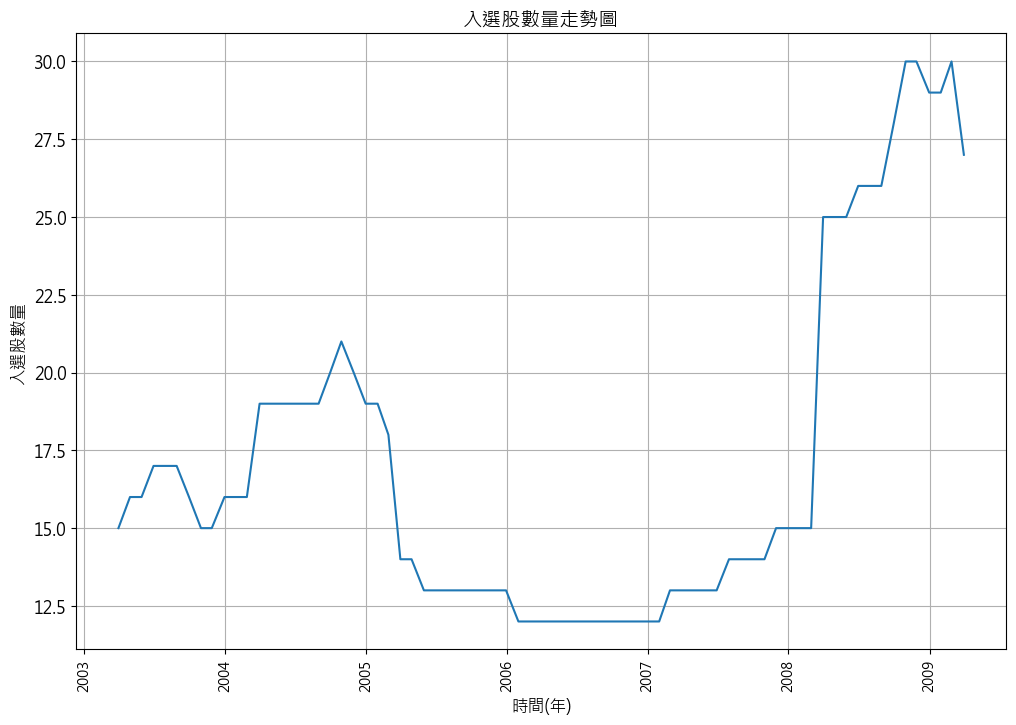

In [47]:
opt_rep_pe.plot_company_counts()

In [63]:
opt_rep_quarter_pe_pos, opt_rep_quarter_pe_neg = opt_rep_pe.calc_returns_contrib(3)

In [51]:
opt_rep_pe_filt = backtest.sim(opt_orig_pe_filt, resample='M', data=data)
opt_rep_pe_filt.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     3.29%  94.09       -50.3%     68.0%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-08-01 2009-04-01     2007-07-31    2009-03-31  0.076923     420   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.083333     484   
CMA      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.047619     253   
EXC      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.047619     253   
FITB     2009-03-02 2009-04-01     2009-02-27    2009-03-31  0.040000      22   
LLY      2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.047619     253   
ABT      2003-04-01        NaT     2003-03-31           NaT  0.071429    5420   
AVY      2003-05-01        NaT     2003-04-30           NaT  0.066667    5399   
BMY      2003-04-01        NaT     2003-03-31           NaT  0.071429    5420   
CL       2008-11-03        NaT     2008-10-31           NaT  0.040000    4011   
GE       2005-04-01        NaT     2005-03-31           NaT  0.076923    4916   
GIS      2008-10-01        NaT     2008-09-30           NaT  0.043478    4034   
GPC      2008-04-01        NaT     2008-03-31           NaT  0.047619    4162   
K        2003-04-01        NaT     2003-03-31           NaT  0.071429    5420   
KMB      2007-12-03        NaT     2007-11-30           NaT  0.071429    4243   
KO       2004-10-01        NaT     2004-09-30           NaT  0.058824    5041   
MAT      2008-04-01        NaT     2008-03-31           NaT  0.047619    4162   
MCHP     2008-10-01        NaT     2008-09-30           NaT  0.043478    4034   
MKC      2008-11-03        NaT     2008-10-31           NaT  0.040000    4011   
MO       2003-04-01        NaT     2003-03-31           NaT  0.071429    5420   
MRK      2003-04-01        NaT     2003-03-31           NaT  0.071429    5420   
PAYX     2008-04-01        NaT     2008-03-31           NaT  0.047619    4162   
PCG      2009-04-01        NaT     2009-03-31           NaT  0.041667    3909   
PII      2009-04-01        NaT     2009-03-31           NaT  0.041667    3909   
PKG      2009-04-01        NaT     2009-03-31           NaT  0.041667    3909   
PPG      2008-04-01        NaT     2008-03-31           NaT  0.047619    4162   
SYY      2008-10-01        NaT     2008-09-30           NaT  0.043478    4034   
USB      2008-04-01        NaT     2008-03-31           NaT  0.047619    4162   
VFC      2009-04-01        NaT     2009-03-31           NaT  0.041667    3909   
WM       2009-04-01        NaT     2009-03-31           NaT  0.041667    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1905        2325  -0.354889 -0.425583   0.102212  0.102212   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CMA              2072        2325  -0.469939 -0.653530   0.159376  0.159376   
EXC              2072        2325  -0.446570 -0.500324   0.110680  0.110680   
FITB             2303        2325   0.735614 -0.270693   0.745614  0.000000   
LLY              2072        2325  -0.329683 -0.446984   0.019683  0.019683   
ABT               814          -1   9.897547 -0.016038  11.675472  0.201887   
AVY               835          -1   6.009256 -0.603460   6.460836  0.469648   
BMY               814          -1   4.494202  0.000000   6.832983  0.000000   
CL               2223          -1   3.529799 -0.127630   3.975755  0.091491   
GE               1318          -1   0.807233 -0.779463   0.829405  0.274923   
GIS              2200          -1   2.414592 -0.317483   3.162824  0.000000   
GPC              2072          -1   4.325466 -0.371851   6.149940  0.091963   
K                 814          -1   4.431892  0.000000   4.460135  0.000000   
KMB              1991          -1   2.833597 -0.338420   3.010354  0.015259   
KO               1193          -1   5.274029 -0.040835   5.579855  0.0145

### 不包含配息率

#### 盈再率 < 80%

In [52]:
# test_noDPR_pe = (test_cond & pe_cond_entry).hold_until((~test_cond) | pe_cond_exit)

In [53]:
# test_pe_rep = backtest.sim(test_noDPR_pe, resample='M', data=data)
# test_pe_rep.get_stats()

In [54]:
# test_pe_rep_pos, test_pe_rep_neg = test_pe_rep.calc_returns_contrib(5)  

### 盈再率 < 40%

In [55]:
opt_noDPR_pe = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_noDPR_pe_filt = (nodpr_cond_opt_filter & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt_filter) | daily_pe_exit[START_DATE:END_DATE])

In [56]:
rep_opt_noDPR_pe = backtest.sim(opt_noDPR_pe, resample='M', data=data)
rep_opt_noDPR_pe.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                      2.3%  97.91       -55.3%    47.83%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-08-01 2009-04-01     2007-07-31    2009-03-31  0.008547     420   
BA       2008-02-01 2009-04-01     2008-01-31    2009-03-31  0.007634     293   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.009009     484   
CBRE     2008-05-01 2009-04-01     2008-04-30    2009-03-31  0.006579     231   
CBSH     2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.009009     484   
...             ...        ...            ...           ...       ...     ...   
WM       2007-05-01        NaT     2007-04-30           NaT  0.009009    4393   
WSM      2007-07-02        NaT     2007-06-29           NaT  0.008850    4350   
WTW      2005-04-01        NaT     2005-03-31           NaT  0.012346    4916   
XOM      2007-05-01        NaT     2007-04-30           NaT  0.009009    4393   
ZBH      2009-04-01        NaT     2009-03-31           NaT  0.005102    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1905        2325  -0.354889 -0.425583   0.102212  0.102212   
BA               2032        2325  -0.567304 -0.633251   0.062187  0.062187   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CBRE             2094        2325  -0.838461 -0.898538   0.032244  0.032244   
CBSH             1841        2325  -0.100845 -0.318666   0.232079  0.232079   
...               ...         ...        ...       ...        ...       ...   
WM               1841          -1   8.079501 -0.368761   8.580034  0.080895   
WSM              1884          -1  12.540669 -0.846080  14.522945  0.129063   
WTW              1318          -1   3.605776 -0.435592   3.780216  0.316953   
XOM              1841          -1   1.841123 -0.415605   1.902755  0.553832   
ZBH              2325          -1   2.189129 -0.000622   4.246111  0.033914   

               mdd   pdays    weight  next_weights  
stock_id                                            
AJG      -0.478850    68.0  0.000000      0.000000  
BA       -0.654723    36.0  0.000000      0.000000  
BXP      -0.699897     6.0  0.000000      0.000000  
CBRE     -0.901708     4.0  0.000000      0.000000  
CBSH     -0.447005   124.0  0.000000      0.000000  
...            ...     ...       ...           ...  
WM       -0.416003  3702.0  0.005102      0.005102  
WSM      -0.863675  3611.0  0.005102      0.005102  
WTW      -0.571429  4080.0  0.005102      0.005102  
XOM      -0.623901  3594.0  0.005102      0.005102  
ZBH      -0.497300  3907.0  0.005102      0.005102  

[231 rows x 16 columns]

In [57]:
# opt_noDPR_pe_pos, opt_noDPR_pe_neg = rep_opt_noDPR_pe.calc_returns_contrib(5)

In [58]:
rep_opt_noDPR_pe_filt = backtest.sim(opt_noDPR_pe_filt, resample='M', data=data)
rep_opt_noDPR_pe_filt.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     4.42%  88.76      -53.17%    50.55%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
AJG      2007-08-01 2009-04-01     2007-07-31    2009-03-31  0.010638     420   
BA       2008-02-01 2009-04-01     2008-01-31    2009-03-31  0.009346     293   
BXP      2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.011364     484   
CBRE     2008-05-01 2009-04-01     2008-04-30    2009-03-31  0.007937     231   
CBSH     2007-05-01 2009-04-01     2007-04-30    2009-03-31  0.011364     484   
...             ...        ...            ...           ...       ...     ...   
WM       2007-05-01        NaT     2007-04-30           NaT  0.011364    4393   
WSM      2007-07-02        NaT     2007-06-29           NaT  0.010989    4350   
WTW      2005-04-01        NaT     2005-03-31           NaT  0.015625    4916   
XOM      2007-05-01        NaT     2007-04-30           NaT  0.011364    4393   
ZBH      2009-04-01        NaT     2009-03-31           NaT  0.005952    3909   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
AJG              1905        2325  -0.354889 -0.425583   0.102212  0.102212   
BA               2032        2325  -0.567304 -0.633251   0.062187  0.062187   
BXP              1841        2325  -0.669468 -0.696786   0.010366  0.010366   
CBRE             2094        2325  -0.838461 -0.898538   0.032244  0.032244   
CBSH             1841        2325  -0.100845 -0.318666   0.232079  0.232079   
...               ...         ...        ...       ...        ...       ...   
WM               1841          -1   8.079501 -0.368761   8.580034  0.080895   
WSM              1884          -1  12.540669 -0.846080  14.522945  0.129063   
WTW              1318          -1   3.605776 -0.435592   3.780216  0.316953   
XOM              1841          -1   1.841123 -0.415605   1.902755  0.553832   
ZBH              2325          -1   2.189129 -0.000622   4.246111  0.033914   

               mdd   pdays    weight  next_weights  
stock_id                                            
AJG      -0.478850    68.0  0.000000      0.000000  
BA       -0.654723    36.0  0.000000      0.000000  
BXP      -0.699897     6.0  0.000000      0.000000  
CBRE     -0.901708     4.0  0.000000      0.000000  
CBSH     -0.447005   124.0  0.000000      0.000000  
...            ...     ...       ...           ...  
WM       -0.416003  3702.0  0.005952      0.005952  
WSM      -0.863675  3611.0  0.005952      0.005952  
WTW      -0.571429  4080.0  0.005952      0.005952  
XOM      -0.623901  3594.0  0.005952      0.005952  
ZBH      -0.497300  3907.0  0.005952      0.005952  

[193 rows x 16 columns]

---

## 上面的入選股數比較

In [59]:
overall_conds = {}

# overall_conds['所有條件_盈再率<80_無本益比'] = orig_cond
overall_conds['所有條件_無本益比'] = orig_cond_opt
overall_conds['所有條件_無本益比_羅素1000'] = orig_cond_opt[filtered_russell_1000_symbol]
# overall_conds['所有條件_盈再率<80_每季本益比'] = orig_quarter_pe
overall_conds['所有條件_有本益比'] = opt_orig_pe
overall_conds['所有條件_有本益比_羅素1000'] = opt_orig_pe_filt
# overall_conds['去掉配息盈再率<80_無本益比'] = test_cond
overall_conds['去掉配息_無本益比'] = nodpr_cond_opt
overall_conds['去掉配息_無本益比_羅素1000'] = nodpr_cond_opt_filter
# overall_conds['去掉配息_盈再率<80_每季本益比'] = test_noDPR_pe
overall_conds['去掉配息_有本益比'] = opt_noDPR_pe
overall_conds['去掉配息_有本益比_羅素1000'] = opt_noDPR_pe_filt


overall_conds['單一條件_ROE五年平均'] = roe_cond[START_DATE:END_DATE]
overall_conds['單一條件_ROE五年平均_羅素1000'] = roe_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]

overall_conds['單一條件_盈再率<40%'] = rr_cond[START_DATE:END_DATE]
overall_conds['單一條件_盈再率<40%_羅素1000'] = rr_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# overall_conds['單一條件_盈再率<80%'] = (rr<0.8)[START_DATE:END_DATE]


overall_conds_collecs = sim_conditions(overall_conds, resample='M', data=data)
overall_conds_collecs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 12/12 [01:21<00:00,  6.81s/condition]


CAGR (%)  MDD (%)  入選股數平均    中位數    25%    75%    Min  \
Strategy                                                                     
單一條件_盈再率<40%_羅素1000      8.43   -50.76  299.86  315.0  264.0  344.0  231.0   
單一條件_盈再率<40%             8.27   -53.08  580.51  602.0  490.0  686.0  425.0   
單一條件_ROE五年平均_羅素1000      7.46   -51.95  239.14  231.0  210.0  269.0  202.0   
單一條件_ROE五年平均             7.33   -52.43  394.78  387.0  342.0  447.0  338.0   
去掉配息_有本益比_羅素1000         4.42   -53.17   82.62   68.0   63.0   96.0   47.0   
去掉配息_無本益比_羅素1000         4.18   -50.70  123.86  114.0  101.0  145.0   89.0   
所有條件_有本益比_羅素1000         3.29   -50.30   15.12   14.0   12.0   16.0   11.0   
去掉配息_無本益比                2.67   -52.79  149.68  136.0  127.0  174.0  109.0   
去掉配息_有本益比                2.30   -55.30  104.33   87.0   81.0  119.0   63.0   
所有條件_無本益比_羅素1000         2.13   -49.98   17.70   17.0   14.0   20.0   13.0   
所有條件_有本益比                1.29   -53.05   17.10   15.0   13.0   19.0   12.0   
所有條件_無本益比                0.53   -52.54   19.67   18.0   15.0   23.0   14.0   

                       Max  
Strategy                    
單一條件_盈再率<40%_羅素1000  354.0  
單一條件_盈再率<40%         724.0  
單一條件_ROE五年平均_羅素1000  307.0  
單一條件_ROE五年平均         497.0  
去掉配息_有本益比_羅素1000     168.0  
去掉配息_無本益比_羅素1000     185.0  
所有條件_有本益比_羅素1000      25.0  
去掉配息_無本益比            215.0  
去掉配息_有本益比            201.0  
所有條件_無本益比_羅素1000      26.0  
所有條件_有本益比             30.0  
所有條件_無本益比             31.0

In [60]:
# output_df = overall_conds_collecs.selected_stock_count_analysis().to_csv('./performance_file/US/美股2003-2009_績效比較_基礎條件.csv', encoding='cp950')

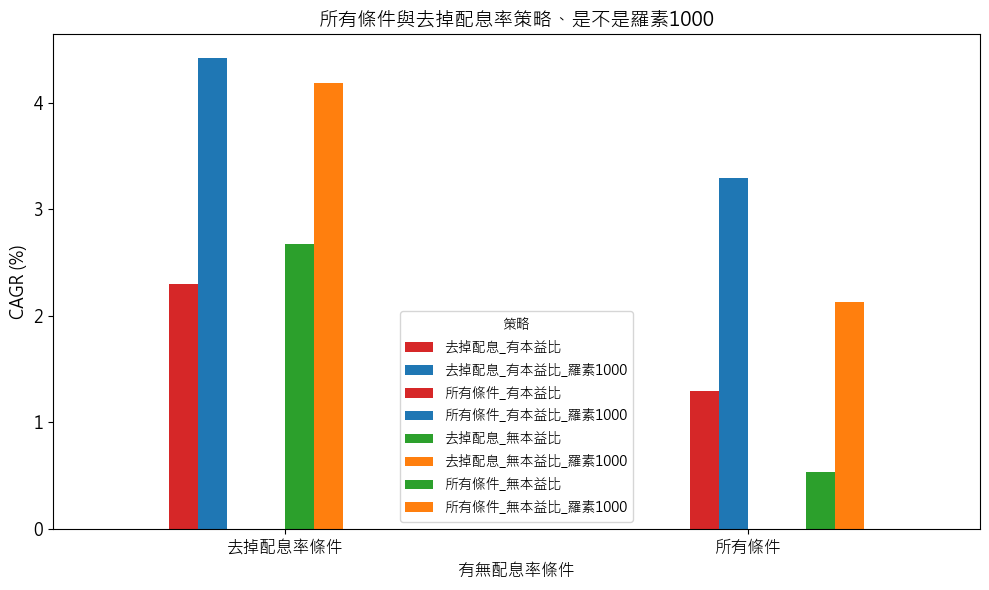

In [61]:
# 重置索引以獲取 'Strategy' 作為欄位
data_df = overall_conds_collecs.selected_stock_count_analysis()
data_df = data_df.reset_index()

# 篩選包含特定條件的資料
filtered_data = data_df[data_df['Strategy'].str.contains('所有條件|去掉配息')].copy()

# 添加 'Group' 欄位
filtered_data['Group'] = filtered_data['Strategy'].apply(
    lambda x: '所有條件' if '所有條件' in x else '去掉配息率條件'
)

# 提取 BaseSuffix
def extract_base_suffix(strategy):
    parts = strategy.split('_')
    if len(parts) > 2:
        return '_'.join(parts[1:])  # 排除前綴
    return parts[-1]  # 使用最後一部分

filtered_data['BaseSuffix'] = filtered_data['Strategy'].apply(extract_base_suffix)

# 添加 'PE_Category' 欄位
filtered_data['PE_Category'] = filtered_data['Strategy'].apply(
    lambda x: '有本益比' if '有本益比' in x else '無本益比'
)

# 為排序新增標籤
filtered_data['SortOrder'] = filtered_data['PE_Category'].map(
    {'有本益比': 0, '無本益比': 1}
)

# 計算 CAGR 平均值並展開表格
grouped = filtered_data.groupby(['Group', 'Strategy'])['CAGR (%)'].mean().unstack()

# 重新排序欄位
ordered_columns = grouped.columns.to_series().sort_values(
    key=lambda x: x.map(filtered_data.set_index('Strategy')['SortOrder'])
).index

grouped = grouped[ordered_columns]

# 生成顏色映射
unique_suffixes = filtered_data['BaseSuffix'].unique()
color_map = {suffix: f'C{i}' for i, suffix in enumerate(unique_suffixes)}
colors = [color_map[extract_base_suffix(col)] for col in grouped.columns]

# 繪製柱狀圖
grouped.plot(kind='bar', figsize=(10, 6), legend=True, rot=0, color=colors)

# 添加標題與軸標籤（繁體中文）
plt.title("所有條件與去掉配息率策略、是不是羅素1000", fontsize=14)
plt.ylabel("CAGR (%)", fontsize=12)
plt.xlabel("有無配息率條件", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="策略", fontsize=10, title_fontsize=10)

# 顯示圖表
plt.tight_layout()
plt.show()


In [62]:
# overall_conds_collecs.plot_reps_stock_counts(['去掉配息盈再率<40_無本益比', '去掉配息_盈再率<40_有本益比', '所有條件_盈再率<40_無本益比', '所有條件_盈再率<40_有本益比', ])

In [63]:
overall_conds_collecs.holding_period_analysis()

CAGR (%)  MDD (%)       持有期間平均     25%     中位數      75%  \
Strategy                                                                       
單一條件_盈再率<40%_羅素1000      8.43   -50.76  1194.990893  393.00  1093.0  1827.00   
單一條件_盈再率<40%             8.27   -53.08  1107.071491  367.00  1034.0  1825.00   
單一條件_ROE五年平均_羅素1000      7.46   -51.95  1246.026253  469.00  1094.0  2191.00   
單一條件_ROE五年平均             7.33   -52.43  1152.578877  393.00  1065.0  1827.00   
去掉配息_有本益比_羅素1000         4.42   -53.17   771.597403  303.00   424.0  1093.00   
去掉配息_無本益比_羅素1000         4.18   -50.70  1032.390805  365.00   731.0  1827.00   
所有條件_有本益比_羅素1000         3.29   -50.30   746.772727  356.50   380.0   746.25   
去掉配息_無本益比                2.67   -52.79   969.919643  365.00   701.0  1556.75   
去掉配息_有本益比                2.30   -55.30   742.101974  276.00   410.5  1051.00   
所有條件_無本益比_羅素1000         2.13   -49.98   876.318182  364.75   700.0  1142.75   
所有條件_有本益比                1.29   -53.05   687.907407  364.00   366.5   731.00   
所有條件_無本益比                0.53   -52.54   793.462963  365.00   393.0   731.75   

                      最大值  最小值  
Strategy                        
單一條件_盈再率<40%_羅素1000  2192   30  
單一條件_盈再率<40%         2192   29  
單一條件_ROE五年平均_羅素1000  2192   28  
單一條件_ROE五年平均         2192   28  
去掉配息_有本益比_羅素1000     2192   29  
去掉配息_無本益比_羅素1000     2192   28  
所有條件_有本益比_羅素1000     2191   30  
去掉配息_無本益比            2192   28  
去掉配息_有本益比            2192   29  
所有條件_無本益比_羅素1000     2191  181  
所有條件_有本益比            2191   30  
所有條件_無本益比            2191  181

In [64]:
# overall_conds_collecs.plot_reps_stock_counts(['去掉配息_盈再率<80_每季本益比', '去掉配息_盈再率<40_每季本益比', '所有條件_盈再率<40_無本益比', '所有條件_盈再率<80_無本益比',  '所有條件_盈再率<40_每季本益比'])

---

## 比較有無其中幾項條件的差異 

In [65]:
import itertools

# 定義所有 DataFrame 名稱及其對應的中文名稱
dataframes = {
    'roe_15': roe_cond[START_DATE:END_DATE],  # 假設這些DataFrame已經存在
    'rr_cond': rr_cond[START_DATE:END_DATE],
    'payout_ratio_cond': payout_cond[START_DATE:END_DATE],
    'profit_cond': netprofit_cond[START_DATE:END_DATE],
    # 'hold_cond': hold_cond,
    'listed': listed_cond[START_DATE:END_DATE]
}

# 定義 DataFrame 對應的中文名稱
dataframe_names = {
    'roe_15': 'ROE五年平均',
    'rr_cond': '盈再率',
    'payout_ratio_cond': '配息率',
    'profit_cond': '稅前淨利',
    # 'hold_cond': '董監持股',
    'listed': '上市櫃滿兩年'
}


# 用於儲存組合結果
compare_conds_strat = {}

# 產生不同長度的組合，從1到6
counter = 1
for r in range(1, len(dataframes) + 1):
    for combination in itertools.combinations(dataframes.keys(), r):
        # 計算DataFrame間的 AND 運算
        combined_signal = dataframes[combination[0]]
        for df_name in combination[1:]:
            combined_signal &= dataframes[df_name]

        # 限制日期區間
        combined_signal = CustomDataFrame(combined_signal)
        combined_signal = combined_signal

        # 使用組合的中文名稱生成key_name
        key_name = "+".join([dataframe_names[df] for df in combination])

        # 將計算結果儲存到字典
        compare_conds_strat[key_name] = combined_signal
        counter += 1




compare_strat_collecs = sim_conditions(compare_conds_strat, resample='M', data=data)

Backtesting progress: 100%|██████████| 31/31 [08:27<00:00, 16.39s/condition]


In [66]:
compare_strat_collecs.selected_stock_count_analysis()

CAGR (%)  MDD (%)   入選股數平均     中位數     25%  \
Strategy                                                                  
上市櫃滿兩年                          10.65   -56.23  1271.21  1261.0  1206.0   
盈再率+上市櫃滿兩年                       8.56   -53.98   542.23   550.0   464.0   
盈再率                              8.27   -53.08   580.51   602.0   490.0   
ROE五年平均+上市櫃滿兩年                   7.46   -53.64   354.74   330.0   317.0   
ROE五年平均                          7.33   -52.43   394.78   387.0   342.0   
ROE五年平均+盈再率                      6.13   -50.97   226.08   209.0   188.0   
ROE五年平均+盈再率+上市櫃滿兩年               6.06   -52.02   212.59   192.0   178.0   
盈再率+配息率                          5.96   -47.45    76.16    68.0    65.0   
盈再率+配息率+上市櫃滿兩年                   5.83   -48.23    73.74    68.0    63.0   
配息率                              4.13   -50.28   186.45   185.0   171.0   
稅前淨利+上市櫃滿兩年                      4.10   -57.46   529.08   549.0   443.0   
配息率+上市櫃滿兩年                       4.00   -51.46   179.15   179.0   167.0   
盈再率+稅前淨利+上市櫃滿兩年                  3.91   -56.22   279.22   282.0   229.0   
盈再率+稅前淨利                         3.81   -54.97   298.68   306.0   242.0   
稅前淨利                             3.71   -55.33   598.23   612.0   512.0   
ROE五年平均+稅前淨利+上市櫃滿兩年              3.28   -53.84   230.45   222.0   193.0   
ROE五年平均+稅前淨利                     3.22   -53.02   246.27   244.0   203.0   
ROE五年平均+盈再率+稅前淨利                 2.75   -51.59   158.66   146.0   134.0   
ROE五年平均+盈再率+稅前淨利+上市櫃滿兩年          2.67   -52.79   149.68   136.0   127.0   
盈再率+配息率+稅前淨利                     2.56   -51.77    38.32    34.0    31.0   
ROE五年平均+配息率                      2.32   -48.96    45.89    46.0    41.0   
ROE五年平均+盈再率+配息率                  2.31   -49.12    27.41    26.0    21.0   
ROE五年平均+配息率+上市櫃滿兩年               2.25   -49.16    45.05    45.0    41.0   
盈再率+配息率+稅前淨利+上市櫃滿兩年              2.24   -52.95    36.81    34.0    30.0   
ROE五年平均+盈再率+配息率+上市櫃滿兩年           2.19   -49.62    26.84    25.0    21.0   
配息率+稅前淨利                         1.34   -57.07    95.44    91.0    87.0   
配息率+稅前淨利+上市櫃滿兩年                  1.09   -58.25    91.27    88.0    83.0   
ROE五年平均+配息率+稅前淨利+上市櫃滿兩年          0.82   -53.09    33.19    33.0    29.0   
ROE五年平均+配息率+稅前淨利                 0.65   -53.34    33.77    33.0    29.0   
ROE五年平均+盈再率+配息率+稅前淨利             0.59   -51.83    20.16    18.0    15.0   
ROE五年平均+盈再率+配息率+稅前淨利+上市櫃滿兩年      0.53   -52.54    19.67    18.0    15.0   

                                75%     Min     Max  
Strategy                                             
上市櫃滿兩年                       1332.0  1166.0  1413.0  
盈再率+上市櫃滿兩年                    636.0   402.0   674.0  
盈再率                           686.0   425.0   724.0  
ROE五年平均+上市櫃滿兩年                393.0   311.0   454.0  
ROE五年平均                       447.0   338.0   497.0  
ROE五年平均+盈再率                   261.0   184.0   316.0  
ROE五年平均+盈再率+上市櫃滿兩年            242.0   174.0   301.0  
盈再率+配息率                        83.0    53.0   111.0  
盈再率+配息率+上市櫃滿兩年                 80.0    51.0   107.0  
配息率                           197.0   169.0   211.0  
稅前淨利+上市櫃滿兩年                   626.0   369.0   643.0  
配息率+上市櫃滿兩年                    186.0   161.0   201.0  
盈再率+稅前淨利+上市櫃滿兩年               348.0   178.0   367.0  
盈再率+稅前淨利                      373.0   192.0   390.0  
稅前淨利                          702.0   428.0   709.0  
ROE五年平均+稅前淨利+上市櫃滿兩年           268.0   176.0   317.0  
ROE五年平均+稅前淨利                  285.0   187.0   336.0  
ROE五年平均+盈再率+稅前淨利              184.0   117.0   225.0  
ROE五年平均+盈再率+稅前淨利+上市櫃滿兩年       174.0   109.0   215.0  
盈再率+配息率+稅前淨利                   41.0    27.0    59.0  
ROE五年平均+配息率                    50.0    37.0    58.0  
ROE五年平均+盈再率+配息率                32.0    19.0    41.0  
ROE五年平均+配息率+上市櫃滿兩年             49.0    36.0    55.0  
盈再率+配息率+稅前淨利+上市櫃滿兩年            39.0    25.0    57.0  
ROE五年平均+盈再率+配息率+上市櫃滿兩年         31.0    19.0    39.0  
配息率+稅前淨利                      106.0    79.0   120.0  
配息率+稅前淨利+上市櫃滿兩年                99.0    77

<Axes: xlabel='date'>

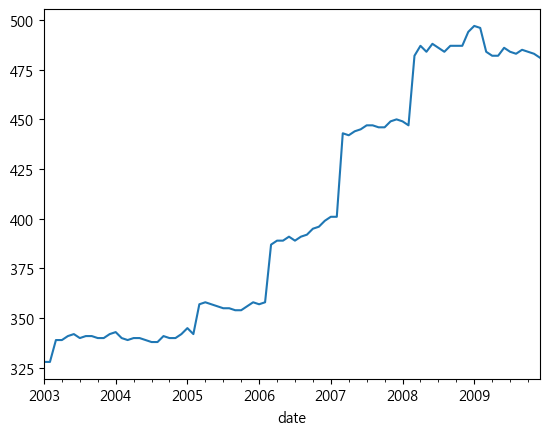

In [58]:
roe_cond['2003':'2009'].sum(axis=1).plot()

<Axes: xlabel='date'>

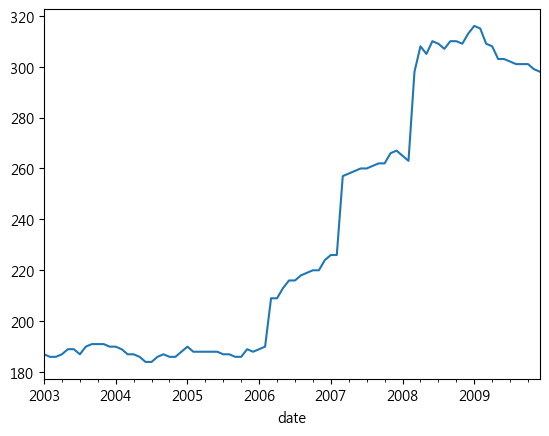

In [60]:
(rr[roe_cond]['2003':'2009'] < 0.4).sum(axis=1).plot()    

In [67]:
# 用於儲存組合結果
compare_conds_strat_PE={}

# 產生不同長度的組合，從1到6
counter = 1
for r in range(1, len(dataframes) + 1):
    for combination in itertools.combinations(dataframes.keys(), r):
        # 計算DataFrame間的 AND 運算
        combined_signal = dataframes[combination[0]]
        for df_name in combination[1:]:
            combined_signal &= dataframes[df_name]

        # 限制日期區間
        combined_signal = CustomDataFrame(combined_signal)
        combined_signal = (combined_signal[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~combined_signal[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])

        # 使用組合的中文名稱生成key_name
        key_name = "+".join([dataframe_names[df] for df in combination])

        # 將計算結果儲存到字典
        compare_conds_strat_PE[key_name] = combined_signal
        counter += 1


compare_strat_collecs_PE = sim_conditions(compare_conds_strat_PE, resample='M', data=data)

Backtesting progress: 100%|██████████| 31/31 [07:20<00:00, 14.20s/condition]


In [68]:
compare_strat_collecs_PE.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均    中位數    25%    75%  \
Strategy                                                                      
上市櫃滿兩年                           7.95   -56.45  761.32  748.0  683.0  818.0   
盈再率                              7.82   -55.19  357.32  321.0  286.0  412.0   
盈再率+上市櫃滿兩年                       7.72   -55.13  347.33  315.0  282.0  393.0   
ROE五年平均                          6.63   -54.24  251.32  226.0  209.0  280.0   
盈再率+配息率                          6.33   -48.73   63.81   60.0   54.0   68.0   
ROE五年平均+上市櫃滿兩年                   6.23   -54.42  240.44  214.0  200.0  260.0   
盈再率+配息率+上市櫃滿兩年                   6.17   -48.85   63.15   60.0   53.0   67.0   
ROE五年平均+盈再率                      5.19   -53.53  141.89  114.0  109.0  154.0   
ROE五年平均+盈再率+上市櫃滿兩年               4.72   -53.95  137.11  110.0  107.0  147.0   
稅前淨利                             4.29   -58.60  410.92  410.0  335.0  497.0   
稅前淨利+上市櫃滿兩年                      4.12   -58.60  393.47  394.0  322.0  469.0   
配息率                              3.89   -51.49  160.85  157.0  152.0  164.0   
盈再率+稅前淨利                         3.82   -57.38  201.27  186.0  154.0  255.0   
配息率+上市櫃滿兩年                       3.77   -51.90  158.23  155.0  150.0  160.0   
盈再率+稅前淨利+上市櫃滿兩年                  3.62   -57.48  195.07  182.0  150.0  245.0   
ROE五年平均+稅前淨利                     3.51   -55.66  177.89  164.0  143.0  206.0   
ROE五年平均+盈再率+配息率                  3.32   -49.38   24.27   23.0   19.0   27.0   
盈再率+配息率+稅前淨利                     3.26   -51.82   33.84   30.0   28.0   36.0   
ROE五年平均+稅前淨利+上市櫃滿兩年              3.20   -55.68  172.05  158.0  137.0  197.0   
盈再率+配息率+稅前淨利+上市櫃滿兩年              3.14   -52.30   33.60   30.0   28.0   36.0   
ROE五年平均+盈再率+配息率+上市櫃滿兩年           2.82   -49.68   23.99   23.0   18.0   27.0   
ROE五年平均+盈再率+稅前淨利                 2.73   -54.84  107.71   91.0   85.0  123.0   
ROE五年平均+配息率                      2.36   -49.52   41.97   41.0   38.0   47.0   
ROE五年平均+盈再率+稅前淨利+上市櫃滿兩年          2.30   -55.30  104.33   87.0   81.0  119.0   
ROE五年平均+配息率+上市櫃滿兩年               2.19   -49.62   41.51   41.0   37.0   46.0   
配息率+稅前淨利                         1.56   -57.47   85.40   82.0   78.0   92.0   
配息率+稅前淨利+上市櫃滿兩年                  1.38   -57.88   83.93   81.0   77.0   90.0   
ROE五年平均+盈再率+配息率+稅前淨利             1.38   -52.57   17.27   15.0   13.0   19.0   
ROE五年平均+盈再率+配息率+稅前淨利+上市櫃滿兩年      1.29   -53.05   17.10   15.0   13.0   19.0   
ROE五年平均+配息率+稅前淨利+上市櫃滿兩年          0.81   -54.44   30.19   29.0   27.0   34.0   
ROE五年平均+配息率+稅前淨利                 0.62   -54.87   30.45   29.0   27.0   35.0   

                               Min     Max  
Strategy                                    
上市櫃滿兩年                       549.0  1078.0  
盈再率                          239.0   587.0  
盈再率+上市櫃滿兩年                   234.0   574.0  
ROE五年平均                      184.0   409.0  
盈再率+配息率                       44.0    99.0  
ROE五年平均+上市櫃滿兩年               181.0   394.0  
盈再率+配息率+上市櫃滿兩年                44.0    97.0  
ROE五年平均+盈再率                   98.0   279.0  
ROE五年平均+盈再率+上市櫃滿兩年            97.0   272.0  
稅前淨利                         243.0   604.0  
稅前淨利+上市櫃滿兩年                  235.0   583.0  
配息率                          147.0   193.0  
盈再率+稅前淨利                     110.0   343.0  
配息率+上市櫃滿兩年                   146.0   187.0  
盈再率+稅前淨利+上市櫃滿兩年              106.0   335.0  
ROE五年平均+稅前淨利                 115.0   299.0  
ROE五年平均+盈再率+配息率               17.0    39.0  
盈再率+配息率+稅前淨利                  23.0    56.0  
ROE五年平均+稅前淨利+上市櫃滿兩年          114.0   291.0  
盈再率+配息率+稅前淨利+上市櫃滿兩年           23.0    55.0  
ROE五年平均+盈再率+配息率+上市櫃滿兩年        17.0    38.0  
ROE五年平均+盈再率+稅前淨利              64.0   206.0  
ROE五年平均+配息率                   34.0    51.0  
ROE五年平均+盈再率+稅前淨利+上市櫃滿兩年       63.0   201.0  
ROE五年平均+配息率+上市櫃滿兩年            33.0    51.0  
配息率+稅前淨利                      68.0   115.0  
配息率+稅前淨利+上市櫃滿兩年               68.0   112.0  
ROE五年平均+盈再率+配息率+稅前淨利          12.0    31.0  
ROE五年平均+盈再率+配息率+稅前淨利+上市櫃滿兩年   12.0    30.0  
ROE五年平均+配息率+稅前淨利+上市櫃滿兩年   

---

---

In [69]:
# test_all = (close > 0)[START_DATE:END_DATE]

In [70]:
# rep_test_all = backtest.sim(test_all, resample='M', data=data)
# rep_test_all.get_stats()

In [71]:
# all_pos, all_neg = rep_test_all.calc_returns_contrib()

In [72]:
# print(all_pos[2008])

In [73]:
# df_rr_test = rr[all_pos[2008]]['2008':'2008']

# # 計算每一列的 NaN 數量
# nan_counts = df_rr_test.isna().sum(axis=1)
# print(nan_counts)

# (df_rr_test < 0.4).sum(axis=1)

---

---

In [74]:
roe_opts = {}

base_conds = rr_cond & netprofit_cond & listed_cond

for n in range(3, 6):
    for k in range(10, 31, 5):

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(n, min_periods=n).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond = roe_rol_opt_df > (k / 100)

        roe_base = (roe_cond & base_conds)[START_DATE:END_DATE]
        roe_payout_base = (roe_cond & base_conds & payout_cond)[START_DATE:END_DATE]

        # 有本益比進出場
        roe_opts[f'ROE{n}y_{k}_去掉配息率條件'] = (roe_base & daily_pe_entry[START_DATE:END_DATE]).hold_until((~roe_base) | daily_pe_exit[START_DATE:END_DATE])
        roe_opts[f'ROE{n}y_{k}_原始條件'] = (roe_payout_base & daily_pe_entry[START_DATE:END_DATE]).hold_until((~roe_payout_base) | daily_pe_exit[START_DATE:END_DATE])

roe_opts_collecs = sim_conditions(roe_opts, resample='M', data=data)

Backtesting progress: 100%|██████████| 30/30 [03:05<00:00,  6.17s/condition]


In [75]:
roe_opts_collecs.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均    中位數    25%    75%   Min    Max
Strategy                                                                     
ROE3y_30_原始條件         6.82   -47.81    4.93    5.0    4.0    5.0   3.0    8.0
ROE4y_25_原始條件         6.50   -48.88    7.84    8.0    6.0    9.0   5.0   11.0
ROE5y_25_原始條件         6.39   -48.88    8.16    8.0    6.0   10.0   5.0   13.0
ROE3y_25_原始條件         5.31   -51.39    7.56    8.0    6.0    9.0   5.0   10.0
ROE5y_30_原始條件         5.28   -52.62    5.77    6.0    5.0    7.0   3.0    9.0
ROE4y_30_原始條件         4.30   -53.54    5.16    5.0    4.0    6.0   4.0    7.0
ROE3y_20_原始條件         4.02   -49.57   11.03   10.0    7.0   13.0   7.0   20.0
ROE5y_20_原始條件         3.55   -49.99   11.52   10.0    9.0   14.0   8.0   18.0
ROE4y_20_原始條件         3.26   -49.30   11.16   11.0    8.0   13.0   7.0   18.0
ROE3y_10_去掉配息率條件      3.15   -56.81  164.48  153.0  116.0  206.0  90.0  293.0
ROE3y_30_去掉配息率條件      3.10   -58.48   26.67   20.0   17.0   34.0  13.0   60.0
ROE5y_10_去掉配息率條件      2.94   -57.25  154.95  136.0  121.0  180.0  88.0  280.0
ROE4y_10_去掉配息率條件      2.77   -57.30  160.48  143.0  118.0  200.0  89.0  285.0
ROE5y_10_原始條件         2.63   -51.46   27.00   25.0   22.0   30.0  18.0   45.0
ROE5y_30_去掉配息率條件      2.63   -58.77   23.97   21.0   20.0   23.0  17.0   48.0
ROE4y_15_去掉配息率條件      2.54   -56.18  113.36   98.0   80.0  139.0  65.0  219.0
ROE3y_10_原始條件         2.43   -53.09   27.04   25.0   22.0   30.0  18.0   44.0
ROE5y_25_去掉配息率條件      2.42   -54.66   35.42   30.0   28.0   34.0  22.0   71.0
ROE4y_30_去掉配息率條件      2.42   -59.78   24.79   20.0   17.0   27.0  14.0   56.0
ROE3y_15_去掉配息率條件      2.38   -56.25  118.04  108.0   72.0  148.0  62.0  230.0
ROE5y_15_去掉配息率條件      2.30   -55.30  104.33   87.0   81.0  119.0  63.0  201.0
ROE4y_10_原始條件         2.12   -53.14   27.10   25.0   22.0   29.0  19.0   44.0
ROE3y_20_去掉配息率條件      2.10   -56.47   69.01   58.0   43.0   87.0  37.0  141.0
ROE3y_25_去掉配息率條件      1.61   -57.81   40.84   31.0   28.0   51.0  22.0   87.0
ROE5y_20_去掉配息率條件      1.38   -55.63   60.48   52.0   47.0   64.0  37.0  118.0
ROE4y_25_去掉配息率條件      1.35   -56.70   38.18   30.0   26.0   42.0  21.0   81.0
ROE5y_15_原始條件         1.29   -53.05   17.10   15.0   13.0   19.0  12.0   30.0
ROE4y_15_原始條件         1.18   -51.63   16.97   16.0   13.0   18.0  12.0   31.0
ROE4y_20_去掉配息率條件      0.97   -57.28   64.53   54.0   44.0   73.0  39.0  135.0
ROE3y_15_原始條件        -0.19   -53.79   17.34   15.0   14.0   18.0  12.0   31.0

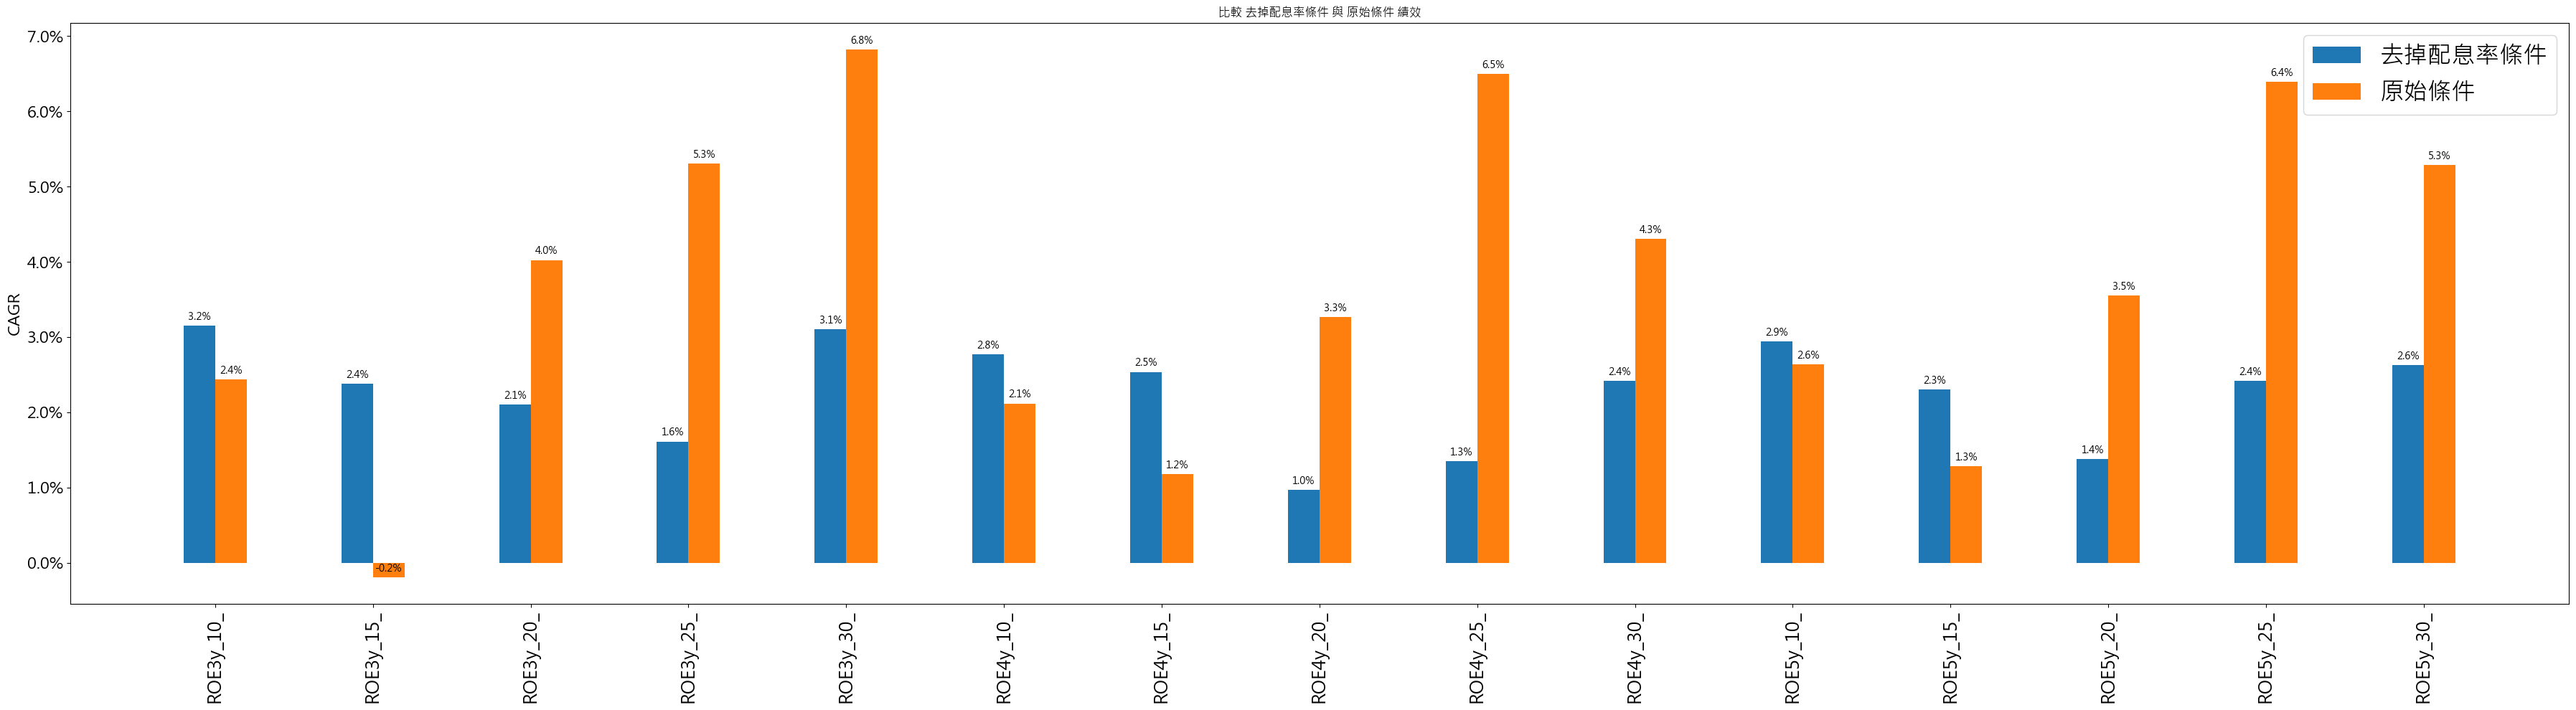

In [76]:
roe_opts_collecs.compare_strat_perform('去掉配息率條件', '原始條件')

## ROE5年平均 + 配息率調整

In [77]:
# payout_roe_opts = {}

# conds_without_roe_payout = rr_cond & netprofit_cond & listed_cond #[START_DATE:END_DATE]

# for i in range(0, 56, 5):
#     # for j in range(10, 13, 2):
#     for k in range(10, 46, 5):

#         # ROE n年平均 > k%
#         df = roe.copy()
#         # 提取index的月份
#         df['month'] = df.index.month
#         # 依據月份分組，對每個月份的每5年計算平均
#         result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
#         # 刪除用來group的欄位
#         roe_rol_opt_df = result.drop(columns='month')
#         roe_cond_opt = roe_rol_opt_df > (k / 100)

#         payout_ratio_cond_opt = payout_ratio_rol >= (i/100)
#         # per_entry_opt = (daily_pe.resample('M').last() < 12)

#         opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
        

#         payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) [filtered_russell_1000_symbol]

#         # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

#         # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

# payout_roe_opts_comb = sim_conditions(payout_roe_opts, resample='M', data=data)

In [78]:
# payout_roe_opts_comb.selected_stock_count_analysis()

In [79]:
# import seaborn as sns

# df = payout_roe_opts_comb.selected_stock_count_analysis()

# # Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
# df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 (N)
# df['X'] = df.index.map(lambda x: x.split('_')[-1])                  # Extracting ROE (X)

# # Converting to numeric types
# df['N'] = pd.to_numeric(df['N'], errors='coerce')
# df['X'] = pd.to_numeric(df['X'], errors='coerce')

# # Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
# heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# # Plotting the heatmap with reversed Y-axis, in coolwarm color scheme, and custom labels
# plt.figure(figsize=(16, 5))
# sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'CAGR (%)'}, 
#             yticklabels=heatmap_data.index[:])
# plt.xlabel("配息率三年至少 (%)")
# plt.ylabel("五年ROE平均 > N %")
# plt.title("【羅素1000】五年平均ROE + 配息率條件 2003~2009")
# plt.show()

In [80]:
# import seaborn as sns
# from matplotlib.colors import ListedColormap

# # 假設這裡是數據準備部分
# df = payout_roe_opts_comb.selected_stock_count_analysis()

# # Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
# df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 (N)
# df['X'] = df.index.map(lambda x: x.split('_')[-1])                  # Extracting ROE (X)

# # Converting to numeric types
# df['N'] = pd.to_numeric(df['N'], errors='coerce')
# df['X'] = pd.to_numeric(df['X'], errors='coerce')

# # Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
# heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# # Creating a mask for cells where 'Min' equals 0
# min_mask_raw = df.pivot(index="X", columns="N", values="Min") == 0

# # Align mask with heatmap_data (ensure same index and columns)
# min_mask = min_mask_raw.reindex(index=heatmap_data.index, columns=heatmap_data.columns).fillna(False)

# # Custom colormap: using "coolwarm" for normal data and "red" for highlighted cells
# normal_cmap = sns.color_palette("coolwarm", as_cmap=True)
# highlight_cmap = ListedColormap(["gray"])

# # Plotting the heatmap
# plt.figure(figsize=(16, 5))
# sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=normal_cmap, cbar_kws={'label': 'CAGR (%)'}, 
#             yticklabels=heatmap_data.index[:])

# # Overlay another heatmap for the highlighted cells
# sns.heatmap(heatmap_data, mask=~min_mask, cmap=highlight_cmap, cbar=False, annot=False)

# # Adding labels and title
# plt.xlabel("配息率三年至少 (%)")
# plt.ylabel("五年ROE平均 > N %")
# plt.title("【羅素1000】五年平均ROE + 配息率條件 2003~2024")
# plt.show()

In [81]:
# payout_roe_opts_comb.reports['配息_10%_ROE_45'].display()

In [82]:
# p, _=payout_roe_opts_comb.reports['配息_0%_ROE_15'].calc_returns_contrib()

In [83]:
# print(p[2008])

---

In [128]:
payout_roe_pe_opts = {}

conds_without_roe_payout = rr_cond & netprofit_cond & listed_cond #[START_DATE:END_DATE]

# for i in range(0, 56, 5):
#     # for j in range(10, 13, 2):
for k in range(10, 46, 5):

    for p in range(8, 19, 2):

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond_opt = roe_rol_opt_df > (k / 100)

        payout_ratio_cond_opt = payout_ratio_rol >= (40/100)

        per_entry_opt = (pe_daily < p)

        opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
        

        payout_roe_pe_opts[f'ROE_{k}_本益比{p}'] = (opt_payout_PER_cond[START_DATE:END_DATE] & per_entry_opt[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) #  [filtered_russell_1000_symbol]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

payout_roe_pe_opts_comb = sim_conditions(payout_roe_pe_opts, resample='M', data=data)

Backtesting progress: 100%|██████████| 48/48 [02:39<00:00,  3.32s/condition]


In [129]:
payout_roe_pe_opts_comb.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min   Max
Strategy                                                             
ROE_40_本益比8      13.49   -38.37    2.11   2.0   1.0   3.0   0.0   5.0
ROE_40_本益比12      9.76   -30.08    3.47   3.0   2.0   5.0   1.0   8.0
ROE_45_本益比8       9.21   -38.35    1.10   1.0   0.0   2.0   0.0   3.0
ROE_40_本益比14      9.15   -32.22    3.67   3.0   2.0   5.0   2.0   8.0
ROE_45_本益比12      8.80   -28.82    2.26   2.0   1.0   3.0   1.0   5.0
ROE_45_本益比16      8.70   -32.22    2.51   2.0   2.0   3.0   1.0   5.0
ROE_45_本益比18      8.49   -32.22    2.52   2.0   2.0   3.0   1.0   5.0
ROE_45_本益比14      8.41   -32.22    2.44   2.0   2.0   3.0   1.0   5.0
ROE_40_本益比16      8.29   -32.22    3.81   3.0   2.0   5.0   2.0   8.0
ROE_40_本益比18      7.67   -32.22    3.82   3.0   2.0   5.0   2.0   8.0
ROE_40_本益比10      7.48   -37.62    3.25   3.0   2.0   4.0   1.0   7.0
ROE_25_本益比10      6.92   -51.17    6.36   6.0   5.0   8.0   4.0  10.0
ROE_25_本益比12      6.39   -48.88    8.16   8.0   6.0  10.0   5.0  13.0
ROE_45_本益比10      6.36   -36.49    2.19   2.0   1.0   3.0   1.0   5.0
ROE_25_本益比14      6.02   -47.42    8.77   9.0   7.0  11.0   5.0  14.0
ROE_30_本益比14      5.94   -50.63    5.97   6.0   5.0   7.0   4.0   9.0
ROE_30_本益比16      5.81   -50.63    6.23   6.0   5.0   8.0   4.0   9.0
ROE_35_本益比14      5.75   -48.80    4.77   4.0   4.0   6.0   3.0   8.0
ROE_30_本益比18      5.47   -50.63    6.29   6.0   5.0   8.0   4.0   9.0
ROE_35_本益比16      5.38   -48.80    4.90   4.0   4.0   6.0   3.0   8.0
ROE_30_本益比12      5.28   -52.62    5.77   6.0   5.0   7.0   3.0   9.0
ROE_35_本益比12      5.22   -50.01    4.56   4.0   4.0   6.0   3.0   8.0
ROE_25_本益比18      5.19   -47.77    9.59   9.0   8.0  12.0   7.0  14.0
ROE_25_本益比16      5.15   -47.77    9.34   9.0   7.0  12.0   6.0  14.0
ROE_35_本益比18      5.04   -48.80    4.92   4.0   4.0   6.0   4.0   8.0
ROE_30_本益比10      4.89   -55.08    5.18   5.0   4.0   6.0   3.0   8.0
ROE_25_本益比8       4.39   -56.26    4.52   4.0   4.0   5.0   3.0   8.0
ROE_35_本益比10      4.15   -54.78    4.34   4.0   3.0   5.0   3.0   7.0
ROE_20_本益比12      3.55   -49.99   11.52  10.0   9.0  14.0   8.0  18.0
ROE_20_本益比10      3.53   -52.69    9.11   8.0   7.0  11.0   6.0  16.0
ROE_20_本益比14      3.31   -48.39   12.27  12.0  10.0  14.0   8.0  18.0
ROE_20_本益比8       3.07   -54.23    6.93   6.0   6.0   7.0   4.0  13.0
ROE_20_本益比18      2.97   -48.70   13.10  13.0  11.0  16.0  10.0  18.0
ROE_20_本益比16      2.89   -48.70   12.85  13.0  10.0  16.0   9.0  18.0
ROE_10_本益比8       2.77   -52.40   18.36  14.0  13.0  21.0  12.0  39.0
ROE_10_本益比12      2.63   -51.46   27.00  25.0  22.0  30.0  18.0  45.0
ROE_10_本益比18      2.44   -51.02   29.07  27.0  24.0  33.0  19.0  45.0
ROE_10_本益比14      2.44   -50.84   28.03  26.0  23.0  31.0  18.0  45.0
ROE_10_本益比10      2.35   -52.59   23.27  20.0  18.0  28.0  14.0  43.0
ROE_10_本益比16      2.28   -51.02   28.81  27.0  24.0  33.0  18.0  45.0
ROE_35_本益比8       2.14   -61.85    3.11   3.0   2.0   3.0   2.0   5.0
ROE_15_本益比12      1.29   -53.05   17.10  15.0  13.0  19.0  12.0  30.0
ROE_15_本益比14      1.21   -51.84   18.07  17.0  13.0  20.0  12.0  30.0
ROE_15_本益比18      1.01   -52.16   18.93  17.0  14.0  22.0  13.0  30.0
ROE_15_本益比16      0.83   -52.16   18.68  17.0  14.0  22.0  12.0  30.0
ROE_30_本益比8       0.40   -62.72    3.55   3.0   3.0   4.0   2.0   6.0
ROE_15_本益比10      0.37   -55.19   13.86  12.0  10.0  15.0   9.0  28.0
ROE_15_本益比8       0.02   -56.70   11.11   9.0   8.0  11.0   8.0  24.0

---

---

## 本益比頻率 - 每季

### 月初、月中、月底

80

In [86]:
# rep_all_cond_and_pe_MS = backtest.sim(orig_quarter_pe, resample='MS', data=data)
# rep_all_cond_and_pe_MS.get_stats()

40

In [87]:
# rep_opt_cond_and_pe_MS = backtest.sim(opt_orig_pe, resample='MS', data=data)
# rep_opt_cond_and_pe_MS.get_stats()

80

In [88]:
# rep_all_cond_and_pe_M15 = backtest.sim(orig_quarter_pe, resample='M', resample_offset='15D', data=data)
# rep_all_cond_and_pe_M15.get_stats()

40

In [89]:
# rep_opt_cond_and_pe_M15 = backtest.sim(opt_orig_pe, resample='M', resample_offset='15D', data=data)
# rep_opt_cond_and_pe_M15.get_stats()

80

In [90]:
# rep_all_cond_and_pe_M = backtest.sim(orig_quarter_pe, resample='M', data=data)
# rep_all_cond_and_pe_M.get_stats()

40

In [91]:
# rep_opt_cond_and_pe_M = backtest.sim(opt_orig_pe, resample='M', data=data)
# rep_opt_cond_and_pe_M.get_stats()

### 每季

In [92]:
# rep_all_cond_and_pe_Q_orig = backtest.sim(opt_orig_pe, resample='Q',data=data)
# rep_all_cond_and_pe_Q_orig.get_stats()

### 每年

In [93]:
# rep_all_cond_and_pe_A = backtest.sim(opt_orig_pe, resample='A', data=data)
# rep_all_cond_and_pe_A.get_stats()

In [94]:
# rep_all_cond_and_pe_A15 = backtest.sim(opt_orig_pe, resample='A', resample_offset="15D",data=data)
# rep_all_cond_and_pe_A15.get_stats()

In [95]:
# rep_all_cond_and_pe_A30 = backtest.sim(opt_orig_pe, resample='A', resample_offset="30D",data=data)
# rep_all_cond_and_pe_A30.get_stats()

In [96]:
# rep_all_cond_and_pe_A45 = backtest.sim(opt_orig_pe, resample='A', resample_offset="45D",data=data)
# rep_all_cond_and_pe_A45.get_stats()

---

## 本益比頻率 - 每日

In [97]:
# daily_pe_entry = pe_daily < 12
# daily_pe_exit = pe_daily > 30

In [98]:
# daily_pe_resample = pe_daily.resample('M').last()[START_DATE:END_DATE]

# daily_pe_entry_M = (daily_pe_resample < 12)
# daily_pe_exit_M = (daily_pe_resample > 30)

### 月初月中月底

In [99]:
# daily_pe_entry_MS = daily_pe_entry.resample('MS').first()
# daily_pe_exit_MS = daily_pe_exit.resample('MS').first()

80

In [100]:
# PE_daily_MS_cond = ((orig_cond & daily_pe_entry_MS).hold_until((~orig_cond) | daily_pe_exit_MS))
# rep_PE_daily_MS_cond = backtest.sim(PE_daily_MS_cond, resample='MS', data=data)
# rep_PE_daily_MS_cond.get_stats()

40

In [101]:
# PE_daily_MS_opt = ((orig_cond_opt & daily_pe_entry_MS).hold_until((~orig_cond_opt) | daily_pe_exit_MS))
# rep_PE_daily_MS_opt = backtest.sim(PE_daily_MS_cond, resample='MS', data=data)
# rep_PE_daily_MS_opt.get_stats()

80

In [102]:
# PE_daily_M_cond = ((orig_cond & daily_pe_entry_M).hold_until((~orig_cond) | daily_pe_exit_M))

In [103]:
# rep_PE_daily_M15_cond = backtest.sim(PE_daily_M_cond, resample='M', resample_offset='15D', data=data)
# rep_PE_daily_M15_cond.get_stats()

40

In [104]:
# PE_daily_M_opt = ((orig_cond_opt & daily_pe_entry_M).hold_until((~orig_cond_opt) | daily_pe_exit_M))

# rep_PE_daily_M15_opt = backtest.sim(PE_daily_M_opt, resample='M', resample_offset='15D', data=data)
# rep_PE_daily_M15_opt.display()

In [105]:
# rep_PE_daily_M_cond = backtest.sim(PE_daily_M_opt, resample='M', data=data)
# rep_PE_daily_M_cond.display()

### 每季

In [106]:
# daily_pe_entry_Q = daily_pe_entry.resample('Q').last()
# daily_pe_exit_Q = daily_pe_exit.resample('Q').last()


# PE_daily_Q_cond = ((orig_cond_opt & daily_pe_entry_Q).hold_until((~orig_cond_opt) | daily_pe_exit_Q))
# rep_PE_daily_Q_cond = backtest.sim(PE_daily_Q_cond, resample='Q', data=data)
# rep_PE_daily_Q_cond.get_stats()

### 每年

In [107]:
# daily_pe_entry_A = daily_pe_entry.resample('A').last()
# daily_pe_exit_A = daily_pe_exit.resample('A').last()


# PE_daily_A_cond = ((orig_cond_opt & daily_pe_entry_A).hold_until((~orig_cond_opt) | daily_pe_exit_A))
# rep_PE_daily_A_cond = backtest.sim(PE_daily_A_cond, resample='A', data=data)
# rep_PE_daily_A_cond.get_stats()

In [108]:
# rep_PE_daily_A15_cond = backtest.sim(PE_daily_A_cond, resample='A', resample_offset='15D',data=data)
# rep_PE_daily_A15_cond.get_stats()

In [109]:
# rep_PE_daily_A30_cond = backtest.sim(PE_daily_A_cond, resample='A', resample_offset='30D',data=data)
# rep_PE_daily_A30_cond.get_stats()

In [110]:
# rep_PE_daily_A45_cond = backtest.sim(PE_daily_A_cond, resample='A', resample_offset='45D',data=data)
# rep_PE_daily_A45_cond.get_stats()

### 每週、每兩週

In [111]:
# daily_pe_entry_W = daily_pe_entry.resample('W').last()
# daily_pe_exit_W = daily_pe_exit.resample('W').last()


# PE_daily_W_cond = ((orig_cond_opt & daily_pe_entry_W).hold_until((~orig_cond_opt) | daily_pe_exit_W))
# rep_PE_daily_W = backtest.sim(PE_daily_W_cond, resample='W', data=data)
# rep_PE_daily_W.get_stats()

In [112]:
# daily_pe_entry_2W = daily_pe_entry.resample('2W').last()
# daily_pe_exit_2W = daily_pe_exit.resample('2W').last()

# PE_daily_2W_cond = ((orig_cond_opt & daily_pe_entry_2W).hold_until((~orig_cond_opt) | daily_pe_exit_2W))
# rep_PE_daily_2W = backtest.sim(PE_daily_2W_cond, resample='2W', data=data)
# rep_PE_daily_2W.get_stats()

### 每日

In [113]:
# PE_daily_D_cond = ((orig_cond_opt & daily_pe_entry).hold_until((~orig_cond_opt) | daily_pe_exit))
# rep_PE_daily_D = backtest.sim(PE_daily_D_cond, resample='D', data=data)
# rep_PE_daily_D.display()

---

---

## 改看稅前淨利

In [114]:
# income_bf_tax

In [115]:
# rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond

# orig_cond_opt_mod = rr_cond & roe_cond & income_bf_tax_cond & payout_cond & listed_cond

In [116]:
# rep_orig_opt_mod = backtest.sim(orig_cond_opt_mod, resample='M', data=data)
# rep_orig_opt_mod.display()

### 含每季本益比進出場

In [117]:
# orig_opt_mod_pe = (orig_cond_opt_mod & pe_cond_entry).hold_until((~orig_cond_opt_mod) | pe_cond_exit)

In [118]:
# rep_orig_opt_mod_pe = backtest.sim(orig_opt_mod_pe, resample='M', data=data)
# rep_orig_opt_mod_pe.display()

---

## 大盤比較

In [119]:
# rua_benchmark = data.get('ruaindex:close')

In [120]:
# # 找出每年的第一天作為 xticks
# year_starts = rua_benchmark.index.to_series().groupby(rua_benchmark.index.year).first()

# # 畫圖
# ax = rua_benchmark.plot(figsize=(24, 6))
# ax.grid(True)

# # 設定 X 軸刻度和標籤
# ax.set_xticks(year_starts.values)  # 使用每年第一天的日期
# ax.set_xticklabels(year_starts.index.astype(str), rotation=90)  # 將年份轉為字串

# plt.show()

In [121]:
# data_tw = Data()

In [122]:
# taiex_benchmark = data_tw.get('taiex:close')

In [123]:
# # 找出每年的第一天作為 xticks
# year_starts = taiex_benchmark.index.to_series().groupby(taiex_benchmark.index.year).first()

# # 畫圖
# ax = taiex_benchmark.plot(figsize=(24, 6))
# ax.grid(True)

# # 設定 X 軸刻度和標籤
# ax.set_xticks(year_starts.values)  # 使用每年第一天的日期
# ax.set_xticklabels(year_starts.index.astype(str), rotation=90)  # 將年份轉為字串

# # 特別標記'2009-03-31'這一天的垂直線，使用紅色虛線
# ax.axvline(pd.Timestamp('2009-03-31'), color='red', linestyle='--')

# plt.show()

In [124]:
# # 創建畫布
# fig, ax1 = plt.subplots(figsize=(24, 6))

# # 畫出 rua_benchmark 的圖，Y 軸在左
# line1, = ax1.plot(rua_benchmark.index, rua_benchmark, label="羅素3000指數", color='tab:blue')
# ax1.set_ylabel("羅素3000指數", color='tab:blue')
# ax1.grid(True)

# # 設定 X 軸刻度和標籤
# ax1.set_xticks(rua_year_starts.values)
# ax1.set_xticklabels(rua_year_starts.index.astype(str), rotation=90)

# # 建立右側的 Y 軸
# ax2 = ax1.twinx()
# line2, = ax2.plot(taiex_benchmark.index, taiex_benchmark, label="台灣加權指數", color='tab:orange')
# ax2.set_ylabel("台灣加權指數", color='tab:orange')

# # 特別標記 '2009-03-31' 的垂直線
# ax1.axvline(pd.Timestamp('2009-03-31'), color='tab:red', linestyle='--')  # 不將這條線加入圖例

# # 添加圖例（只包含台灣加權指數和羅素3000指數）
# fig.legend(handles=[line1, line2], loc="upper left", bbox_to_anchor=(0.1, 0.9), fontsize=14)

# # 顯示圖表
# plt.show()
